In [1]:
#Import necessary packages
import numpy as np
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras.models import load_model
import matplotlib.pyplot as plt
import keras.backend as K

Using TensorFlow backend.


#Part 1: Implementing the GAN

In [2]:
#Load MNIST data and normalize to [-1, 1]
(data_train, _), (data_test, _) = mnist.load_data()
data_train=(2*data_train.astype('float32')-255)/255
data_test=(2*data_test.astype('float32')-255)/255
data_train=data_train.reshape(60000,784)
data_test =data_test.reshape(10000,784)
print(data_train.shape)

(60000, 784)


W1025 16:04:31.360666 139802737756032 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1025 16:04:31.365561 139802737756032 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1025 16:04:31.370413 139802737756032 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1025 16:04:31.434173 139802737756032 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1025 16:04:31.441828 139802737756032 module_wrapper.py:139] From /usr/local

Epoch 10000
10000: [Discriminaotr loss: 0.540320, acc: 0.761719]  [GAN loss: 1.335193, acc: 0.148438]


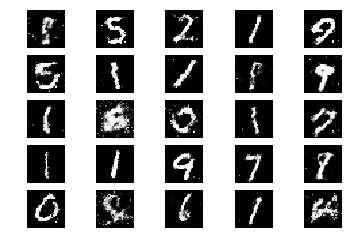

Epoch 20000
20000: [Discriminaotr loss: 0.522666, acc: 0.773438]  [GAN loss: 1.966614, acc: 0.101562]


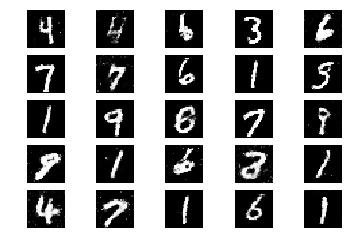

Epoch 30000
30000: [Discriminaotr loss: 0.526628, acc: 0.773438]  [GAN loss: 1.517093, acc: 0.078125]


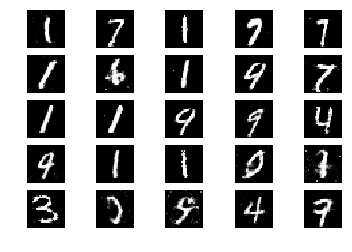

Epoch 40000
40000: [Discriminaotr loss: 0.559446, acc: 0.757812]  [GAN loss: 1.852928, acc: 0.085938]


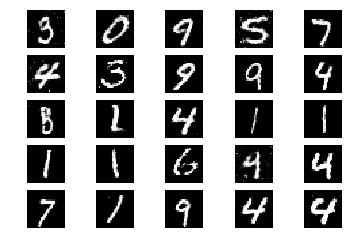

Epoch 50000
50000: [Discriminaotr loss: 0.499414, acc: 0.796875]  [GAN loss: 1.762602, acc: 0.070312]


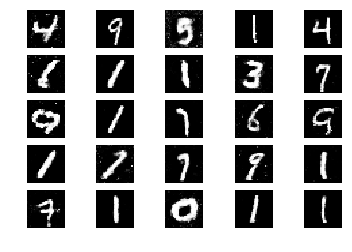

Epoch 60000
60000: [Discriminaotr loss: 0.517095, acc: 0.761719]  [GAN loss: 1.600561, acc: 0.070312]


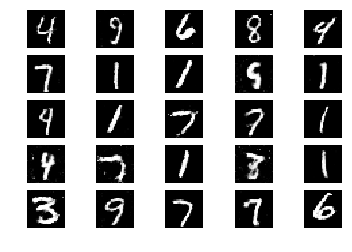

Epoch 70000
70000: [Discriminaotr loss: 0.562124, acc: 0.742188]  [GAN loss: 1.211607, acc: 0.234375]


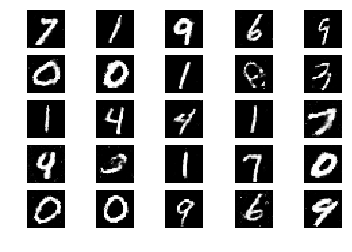

Epoch 80000
80000: [Discriminaotr loss: 0.526211, acc: 0.757812]  [GAN loss: 2.203152, acc: 0.031250]


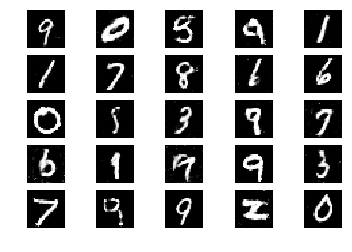

Epoch 90000
90000: [Discriminaotr loss: 0.523107, acc: 0.753906]  [GAN loss: 1.114650, acc: 0.242188]


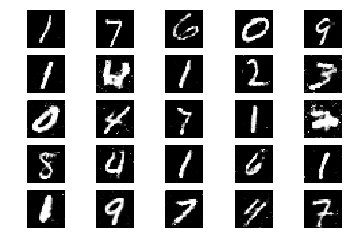

Epoch 100000
100000: [Discriminaotr loss: 0.563545, acc: 0.718750]  [GAN loss: 1.662247, acc: 0.093750]


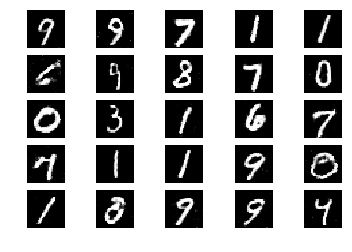

In [3]:

# The D-dimensional noise vector length
latent_dim = 100

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def adam_optimizer():
    return adam(lr=0.0002, beta_1=0.5)
  
  
def gan_adam_optimizer():
    return adam(lr=0.0001, beta_1=0.5)
  
def accuracy(y_pred, y_true):
	return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

# Genrerator model
def create_generator():
    generator = Sequential()
    generator.add(Dense(250,input_dim=100))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(550))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(1100))
    generator.add(LeakyReLU(0.1))
    generator.add(Dense(784,activation='tanh'))
    generator.compile(loss='binary_crossentropy',optimizer=adam_optimizer() )
    
    return generator
    

# Discriminator model
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1100,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.1))
    discriminator.add(Dense(550))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.1))
    discriminator.add(Dense(250))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.1))
    discriminator.add(Dense(1,activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy',optimizer=adam_optimizer(), metrics=[accuracy])    
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input=Input(shape=(100,))
    x=generator(gan_input)
    gan_output=discriminator(x)
    gan = Model(inputs=gan_input,outputs=gan_output)
    gan.compile(loss='binary_crossentropy',optimizer=gan_adam_optimizer( ),metrics=[accuracy])
    return gan


# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000
batch_size = 128
sample_interval = 10000

# Array to save training history
training_meta_data = np.zeros([epochs, 4])

# Training the GAN
for e in range(1, epochs+1):

    # Generate random noise as input
    noise=np.random.normal(loc=0.0, scale=1.0, size=(batch_size,100))

    # Generate fake MNIST images from generated noise
    fake_images=generator.predict(noise)

    # Get a random set of real MNIST images
    real_images=data_train[np.random.choice(len(data_train),batch_size)]
    #print(real_images.shape)
    #print(fake_images.shape)

    # Concatenate real and fake images into a single array (or batch)
    data_total=np.concatenate((real_images, fake_images))

    # Assign training labels (assign high probability, but not 1, to real images)
    labels_real=np.ones(batch_size)*0.9
    labels_fake=np.ones(batch_size)*0
    labels_discriminator=np.concatenate((labels_real, labels_fake))


    # Allow discriminator parameters to be updated
    discriminator.trainable=True
    
    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss=np.empty(2)
    d_loss[0], d_loss[1]=discriminator.train_on_batch(data_total,labels_discriminator)
    

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise=np.random.normal(loc=0.0, scale=1.0, size=(batch_size,100))
    labels_generator=np.ones(batch_size)

    # Keep discriminator weights constant while training generator
    discriminator.trainable=False

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss=np.empty(2)
    gan_loss[0], gan_loss[1]=gan.train_on_batch(noise,labels_generator )
    #print(d_loss,gan_loss)
    

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]

    
    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
        print("Epoch %d" %e)
        log_mesg = "%d: [Discriminaotr loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

#Part 2: Generating samples using trained generator

In [0]:
# Generate ten images from Gaussian noise using the trained generator from Part 1
noise=np.random.normal(loc=0.0, scale=1.0, size=(10,100))
predicted=generator.predict(noise)
# Re-scale generated images to lie in [0, 1]
predicted=(predicted-predicted.min())/(predicted.max()-predicted.min())


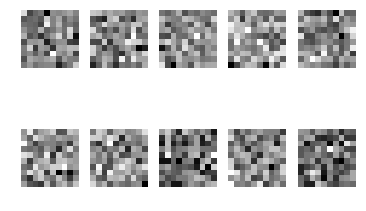

In [7]:
# Visualize generated noise
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((noise[cnt].reshape(10, 10)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

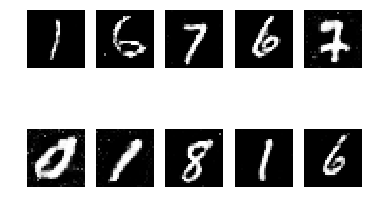

In [8]:
# Visualize generated samples
generated_images=predicted
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((generated_images[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

#Part 3: Testing accuracy of generated images on ten samples

In [9]:
# Load mnist classifier and generated images
mnist_classifier = load_model('mnist_classifier.h5')

W1025 19:37:48.789625 139802737756032 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



In [11]:
# ASSIGN CLASSES
labels = [1,6,7,6,7,0,1,8,4,6]

# Convert integer labels to one-hot labels 
labels = keras.utils.np_utils.to_categorical(labels, num_classes=10)

# Show classifications
classified=mnist_classifier.predict(predicted)
print('****************The output of MNIST classifier**********************')
print(classified)


print('****************The labels predicted by MNIST classifier**********************')
for i in range(10):
  index=0
  maximum=0
  for j in range(10):
    if classified[i][j]>maximum:
      maximum=classified[i][j]
      index=j
  print(index)
    
    
# Evaluate accuracy
print('The accuracy is: '+str(mnist_classifier.evaluate(predicted,labels)[1]*100))




****************The output of MNIST classifier**********************
[[1.45381769e-27 1.00000000e+00 6.63942787e-20 4.12481791e-32
  8.45994146e-14 3.50232310e-21 2.93306322e-20 7.95854620e-21
  1.64598619e-17 3.93140881e-26]
 [1.05071956e-18 2.36961259e-26 5.81465521e-27 9.20485518e-29
  3.61429466e-23 3.51364662e-12 1.00000000e+00 3.35660178e-32
  5.27472151e-30 8.17536172e-28]
 [9.55500716e-37 1.53352539e-25 8.91823662e-24 2.70056374e-25
  3.70159608e-33 2.14885304e-31 0.00000000e+00 1.00000000e+00
  8.64944614e-27 2.82207140e-24]
 [1.12231640e-30 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.79010770e-36 9.44223478e-32 1.00000000e+00 0.00000000e+00
  1.48129785e-36 0.00000000e+00]
 [0.00000000e+00 6.10147125e-28 1.06621776e-07 1.03351967e-08
  5.85087895e-34 1.50886064e-21 0.00000000e+00 9.99999881e-01
  1.23938335e-32 1.82658459e-37]
 [1.00000000e+00 2.04724335e-33 1.69658169e-20 2.45251119e-33
  9.33289080e-20 1.67983322e-33 1.56920335e-25 4.60827810e-24
  2.11688740e-30 2.942